## <center>Card Fraud Detection Boosting</center>

### Importing packages and data

In [1]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./boosting.ipynb
./credit-card-fraud-detection-boosting.ipynb
./creditcard.csv
./creditcard.csv.zip
./DATASET\creditcard.csv


In [2]:
#importing dataset
df = pd.read_csv("DATASET/creditcard.csv")
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data processing and undersampling

"Time" tidak diperlukan untuk klasifikasi sehingga saya hanya menghapus feature dari dataset :

In [3]:
df = df.drop("Time", axis=1)

Kita perlu menstandarisasi fitur 'Amount' sebelum modeling.
Untuk itu, kita menggunakan fungsi StandardScaler dari sklearn. Kemudian, kita hanya perlu menghapus feature lama :

In [4]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [5]:
#standarisasi Amount
df['std_Amount'] = scaler.fit_transform(df['Amount'].values.reshape (-1,1))

#menghapus kolom Amount
df = df.drop("Amount", axis=1)

<Axes: xlabel='Class', ylabel='count'>

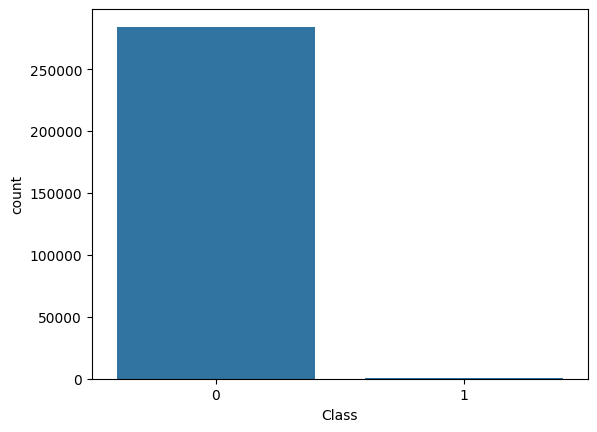

In [6]:
sns.countplot(x="Class", data=df)

Dataset ini sangat tidak seimbang,
Ini masalah besar karena classifier akan selalu memprediksi class yang paling umum tanpa menganalisis fitur-fitur, dan akan tampak memiliki akurasi tinggi, meski salah. Untuk mengatasi ini, kita akan menggunakan undersampling acak.

Undersampling acak melibatkan pemilihan contoh secara acak dari class mayoritas dan menghapusnya dari dataset pelatihan. Meskipun sederhana dan efektif, teknik ini bisa menghapus informasi yang penting untuk menentukan "boundary" antara class. Ini berarti mungkin, atau bahkan kemungkinan besar, informasi yang berguna akan dihapus.

### <center>Cara kerja undersampling :</center>
<center><img src= "https://miro.medium.com/max/335/1*YH_vPYQEDIW0JoUYMeLz_A.png">

Untuk undersampling, kita bisa menggunakan paket imblearn dengan fungsi RandomUnderSampler!

In [7]:
from imblearn.under_sampling import RandomUnderSampler 

undersample = RandomUnderSampler(sampling_strategy=0.5)

In [8]:
cols = df.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

In [9]:
#define X and Y
X = df[cols]
Y = df[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)

In [10]:
test = pd.DataFrame(Y_under, columns = ['Class'])

Text(0.5, 1.0, 'After')

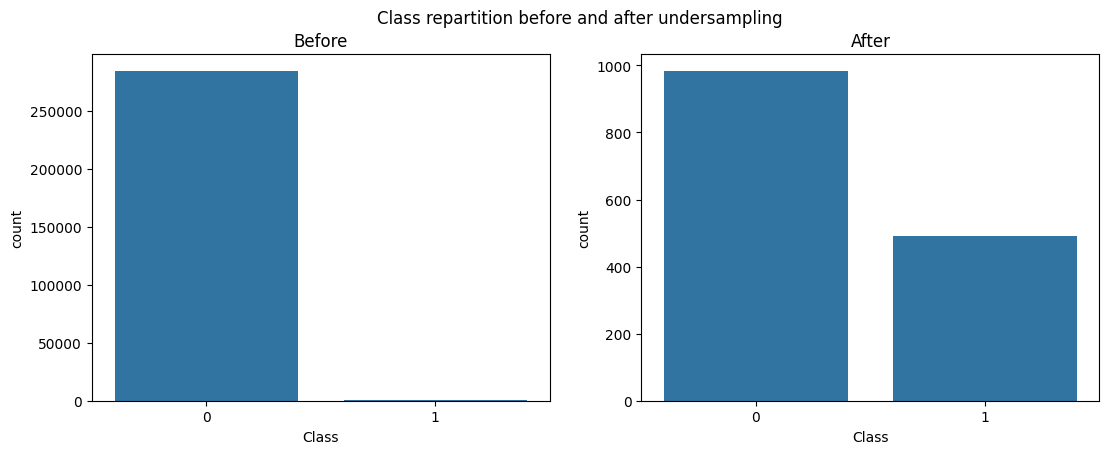

In [11]:
#visualisasi hasil undersampling
fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sns.countplot(x="Class", data=df, ax=axs[0])
sns.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

Setelah Seimbang, langkah terakhir sebelum pemodelan adalah membagi data menjadi sampel train dan test. Set test akan terdiri dari 20% data.

Kita akan menggunakan dataset pelatihan untuk melatih model kita dan kemudian mengevaluasinya pada set test:

<center><img src="https://data-flair.training/blogs/wp-content/uploads/sites/2/2018/08/1-16.png"></center>
<center>Untuk membagi data, kita bisa menggunakan fungsi train_test_split dari sklearn</center>

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=1)

# Modeling Ensemble learning : Boosting (XGBoost)

In [13]:
#importing packages for modeling
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

### <center> Cara Kerja XGBoost :</center>

![](https://d1rwhvwstyk9gu.cloudfront.net/2020/02/XG-Boost-FINAL-01.png)

Metode ensemble sequential, juga dikenal sebagai "boosting", membuat serangkaian model yang mencoba memperbaiki kesalahan dari model sebelumnya dalam urutan tersebut. Model pertama dibangun pada data pelatihan, model kedua memperbaiki model pertama, model ketiga memperbaiki model kedua, dan seterusnya.

## Training model

In [14]:
model = XGBClassifier(random_state=2)
xgb = model.fit(X_train, y_train)

### Predict

In [15]:
y_pred_xgb = model.predict(X_test) 

### Scores

In [16]:
print("Accuracy XGB:",metrics.accuracy_score(y_test, y_pred_xgb))
print("Precision XGB:",metrics.precision_score(y_test, y_pred_xgb))
print("Recall XGB:",metrics.recall_score(y_test, y_pred_xgb))
print("F1 Score XGB:",metrics.f1_score(y_test, y_pred_xgb))

Accuracy XGB: 0.9425675675675675
Precision XGB: 0.941747572815534
Recall XGB: 0.8981481481481481
F1 Score XGB: 0.919431279620853


### Confusion matrix
<!-- pengertian singkat -->
Confusion matrix adalah tabel yang digunakan untuk mengevaluasi kinerja sebuah model klasifikasi. Tabel ini menunjukkan perbandingan antara prediksi model dengan nilai aktual (ground truth). Dalam matriks ini, ada empat elemen penting:

- <strong>True Positive (TP)</strong>: Jumlah kasus positif yang diprediksi benar oleh model. Misalnya, dalam kasus deteksi penipuan kartu kredit, ini adalah jumlah transaksi penipuan yang benar-benar terdeteksi sebagai penipuan.

- <strong>True Negative (TN)</strong>: Jumlah kasus negatif yang diprediksi benar oleh model. Ini adalah jumlah transaksi tidak penipuan yang benar-benar terdeteksi sebagai tidak penipuan.

- <strong>False Positive (FP)</strong>: Jumlah kasus negatif yang diprediksi salah sebagai positif oleh model. Ini adalah jumlah transaksi tidak penipuan yang salah terdeteksi sebagai penipuan (false alarm).

- <strong>False Negative (FN)</strong>: Jumlah kasus positif yang diprediksi salah sebagai negatif oleh model. Ini adalah jumlah transaksi penipuan yang salah terdeteksi sebagai tidak penipuan (missed fraud).

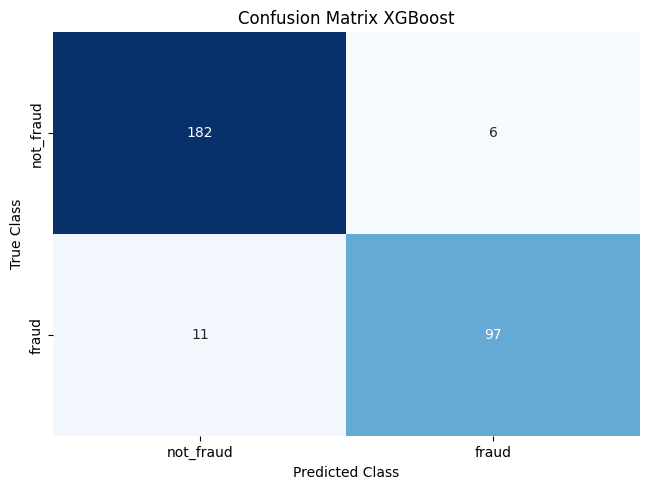

In [17]:
matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb = pd.DataFrame(matrix_xgb, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_xgb, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix XGBoost"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [18]:
y_pred_xgb_proba = model.predict_proba(X_test)[::,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  y_pred_xgb_proba)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_xgb_proba)
print("AUC XGBoost :", auc_xgb)

AUC XGBoost : 0.9762115839243499


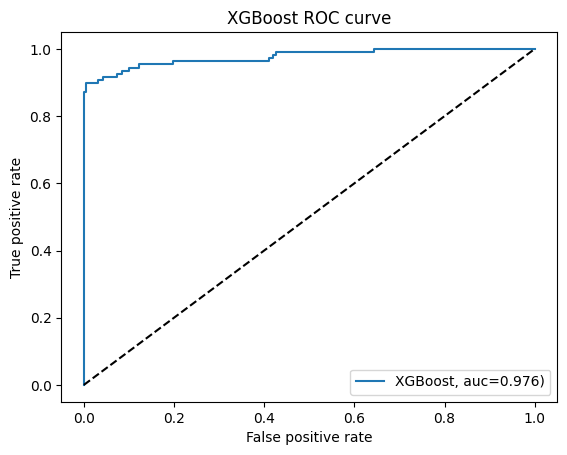

In [19]:
#ROC
plt.plot(fpr_xgb,tpr_xgb,label="XGBoost, auc={:.3f})".format(auc_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('XGBoost ROC curve')
plt.legend(loc=4)
plt.show()

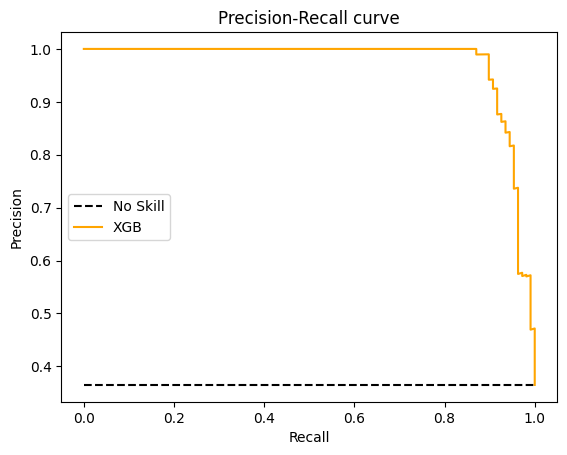

In [20]:
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_pred_xgb_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(xgb_recall, xgb_precision, color='orange', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

### Conclusion

In [21]:
print("Accuracy XGB:",metrics.accuracy_score(y_test, y_pred_xgb))
print("Precision XGB:",metrics.precision_score(y_test, y_pred_xgb))
print("Recall XGB:",metrics.recall_score(y_test, y_pred_xgb))
print("F1 Score XGB:",metrics.f1_score(y_test, y_pred_xgb))
print("AUC XGBoost :", auc_xgb)

Accuracy XGB: 0.9425675675675675
Precision XGB: 0.941747572815534
Recall XGB: 0.8981481481481481
F1 Score XGB: 0.919431279620853
AUC XGBoost : 0.9762115839243499
